In [42]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [3]:
# Load the data
df = pd.read_csv("../../DataSet/fer2013.csv")

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [97]:
# Num of samples for each class
df[df.Usage=="Training"].emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Class 1 has minor smaples so need to oversample this class 1. To avoid data leakage oversampling will be applied to Training data 

In [37]:
# input and output features
X = df.pixels.str.split(" ", expand=True).to_numpy() # Break the pixels string into individual columns
Y = df.emotion.to_numpy() # Emotion Array

In [64]:
print(X.shape, Y.shape)

(35887, 2304) (35887,)


In [65]:
# Turn each pixel into a float and normalize to 0 to 1
X = X.astype(np.int) / 255.0

In [180]:
# Split the data into train and test -> Final 3600 samples for Test and Rest is for Train
Xtrain, Xtest, Ytrain, Ytest = X[:-3600], X[-3600:], Y[:-3600], Y[-3600:]

In [181]:
print(Xtrain.shape, Xtest.shape)

(32287, 2304) (3600, 2304)


In [182]:
# Check again the class imbalanceness
print("Minor class samples:", Ytrain[Ytrain==1].shape[0]) # minor class

# Imbalnce ratio of class 1 relative to class 0
r = Ytrain[Ytrain==0].shape[0] / Ytrain[Ytrain==1].shape[0]
print("Imbalance Ratio", r)

Minor class samples: 491
Imbalance Ratio 9.087576374745417


In [183]:
# Apply oversampling
Px = np.repeat(Xtrain[Ytrain==1], 8, axis=0)
Py = np.repeat(Ytrain[Ytrain==1], 8, axis=0)

# combine to Original Xtrain
Xtrain = np.vstack((Xtrain,Px))
Ytrain = np.vstack((Ytrain.reshape(1,Ytrain.shape[0]).T,Py.reshape(1,Py.shape[0]).T))

# Flat the Ytrain
Ytrain = Ytrain.reshape(-1)

print(Xtrain.shape, Ytrain.shape)

(36215, 2304) (36215,)


In [184]:
# Shuffle training data
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [185]:
def showPhoto(x,y):
    emotion={
        0: "Angry",
        1: "Disgust",
        2: "Fear",
        3: "Happy",
        4: "Sad",
        5: "Surprise",
        6: "Neutral"
    }
    plt.title("Emotion: "+emotion[y])
    plt.imshow(x.reshape(48,48))
    plt.show()

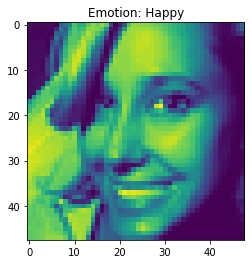

In [202]:
# Testing a photo
photo_id = 8000
showPhoto(Xtrain[photo_id], Ytrain[photo_id])

In [85]:
def oneHotEncode(y):
    # Target index matrix from Ytrain
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))

    for i,val in enumerate(y):
        T[i,val] = 1

    return T

In [86]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [87]:
def tanh(z):
    return (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))

In [88]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [89]:
def nonlinearDT(z, func):
    if func == "sigmoid":
        return z*(1-z)
    if func == "tanh":
        return (1-z**2)

In [90]:
def cost(t,y):
    return -np.mean(t*np.log(y))

In [210]:
def forwardProp(X,T,Xtest,Ytest,h_layers,lr,activation_func,W,B,A,n,random_state):

    D = X.shape[1] # N.Input nodes
    K = T.shape[1] # N.Output nodes
    L = len(h_layers) # N.Hidden Layers
    A_test = {} # Test output at each layer
    np.random.seed(random_state) # Seed

    for i in range(L+1): # including output layer
        if i==0: # At First Layer
            if n==0:
                W[i] = np.random.randn(D,h_layers[i])
                B[i]  = np.random.randn(h_layers[i])
            Z = np.dot(X, W[i]) + B[i]
            A[i] = activation_func(Z)
            
            Z_test = np.dot(Xtest, W[i]) + B[i]
            A_test[i] = activation_func(Z_test)
            
        elif i==L: # At Last Layer
            if n==0:
                W[i] = np.random.randn(h_layers[i-1], K)
                B[i] = np.random.randn(K)
            Z = np.dot(A[i-1], W[i]) + B[i]
            A[i] = softmax(Z) # Multiclass Classification
            
            Z_test = np.dot(A_test[i-1], W[i]) + B[i]
            A_test[i] = softmax(Z_test)

        else: # At Middle Layers
            if n==0:
                W[i] = np.random.randn(h_layers[i-1], h_layers[i])
                B[i] = np.random.randn(h_layers[i])
            Z = np.dot(A[i-1], W[i]) + B[i]
            A[i] = activation_func(Z)
            
            Z_test = np.dot(A_test[i-1], W[i]) + B[i]
            A_test[i] = activation_func(Z_test) 
            
    return W,B,A,A_test[list(A_test.keys())[-1]]

In [211]:
def backProp(X,T,h_layers,lr,activation_func,W,B,A):
    
    Y = A[list(A.keys())[-1]] # Predicted Output
    L = len(h_layers) # N.Hidden Layers
    error, delta = {}, {}
    
    for i in range(L,-1,-1):
        if i==L: # At Last Layer
            error[i] = T-Y
            delta[i] = error[i] # softmax layer
            W[i] += lr*np.dot(A[i-1].T, delta[i])
            B[i] += lr*np.sum(delta[i], axis=0)
            #print(B[i])
        elif i==0: # At First Layer
            error[i] = np.dot(delta[i+1], W[i+1].T)
            delta[i] = error[i]*nonlinearDT(A[i], activation_func.__name__)
            W[i] += lr*np.dot(X.T, delta[i])
            B[i] += lr*np.sum(delta[i], axis=0)
            
        else: # At Middle Layers
            error[i] = np.dot(delta[i+1], W[i+1].T)
            delta[i] = error[i]*nonlinearDT(A[i], activation_func.__name__)
            W[i] += lr*np.dot(A[i-1].T, delta[i])
            B[i] += lr*np.sum(delta[i], axis=0)
            
    return W, B, Y

In [212]:
def fit(X, Y, Xtest, Ytest, h_layers=[2], lr=0.01, activation_func=sigmoid, iterations=100, random_state=1):
    
    T = oneHotEncode(Y) # Apply One hot encoding
    T_test = oneHotEncode(Ytest)
    
    W, B, A = {}, {}, {} # weights, biases and outputs at each layers
    ctrain, ctest = [], [] # Costs
    
    for n in range(iterations):
        W, B, A, Yhat = forwardProp(X,T,Xtest,Ytest,h_layers,lr,activation_func,W,B,A,n,random_state)
        W, B, Y = backProp(X,T,h_layers,lr,activation_func,W,B,A)

        ctrain.append(cost(T,Y))
        ctest.append(cost(T_test,Yhat))
    
    _, _, _, Yhat = forwardProp(X,T,Xtest,Ytest,h_layers,lr,activation_func,W,B,A,n,random_state) # Final output test 
    
    Yhat_train = predict(Y) # Final Prediction for Training Data
    Yhat_test = predict(Yhat) # Final Prediction for Testing Data
    
    return ctrain, ctest, Yhat_train, Yhat_test, W, B

In [213]:
def predict(y):
    return np.argmax(y, axis=1)

In [214]:
def accuracy(y, yhat):
    return np.mean(y==yhat)

In [ ]:
# Train DNN
Ctrain, Ctest, Yhat_train, Yhat_test, W, B = fit(
    Xtrain, Ytrain, Xtest, Ytest, h_layers=[200,100], lr=0.000001, activation_func=tanh, iterations=100000, random_state=1)

In [247]:
# Accuracy
train_result = accuracy(Ytrain, Yhat_train)
test_result = accuracy(Ytest, Yhat_test)
print("Training Accuracy: {}%".format(train_result*100))
print("Testing Accuracy: {}%".format(test_result*100))

Training Accuracy: 22.824796355101476%
Testing Accuracy: 22.72222222222222%


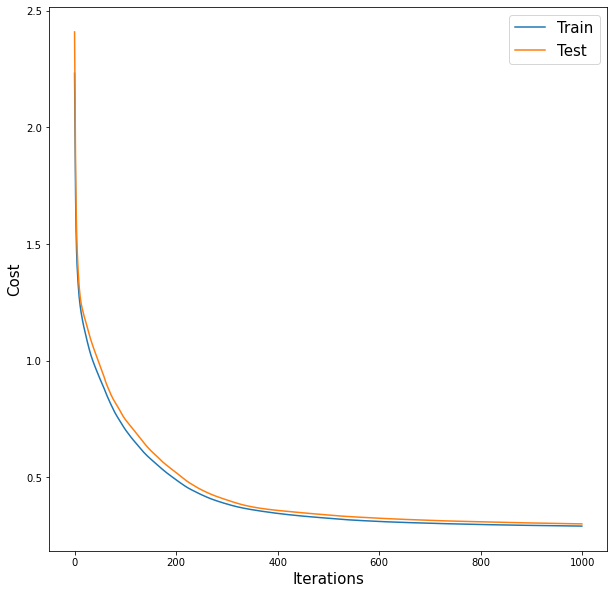

In [248]:
# Cost plot
plt.figure(figsize=(10,10))
plt.plot(Ctrain, label="Train")
plt.plot(Ctest, label="Test")
plt.legend(fontsize=15)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.show()